<a href="https://colab.research.google.com/github/lisboaeric/ProjetoMachineLearning/blob/main/Split_or_Steal_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Eric Lisboa e Mateus Torres

In [ ]:
import zipfile
import os

# Caminho para o arquivo zip
zip_path = "/content/SplitOrSteal v1.2.zip"

# Caminho de destino
extract_path = "/content/split_or_steal"

# Extrair o zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar se os arquivos foram extraídos
os.listdir(extract_path)

['SplitOrSteal']

Como o SimpleRL do código utiliza o método do Q-Learning (Atualiza a Q-table com base na melhor ação futura esperada), colocamos no espaço do your_agent o agente SARSA (Atualiza com base na ação que foi realmente escolhida no próximo estado, não na melhor possível).

Q-Learning é um algoritmo de aprendizado por reforço do tipo off-policy. Isso significa que ele aprende a melhor política de decisão possível independentemente das ações que o agente realmente executa. A cada passo, o agente atualiza sua tabela Q com base na melhor ação possível no próximo estado, mesmo que ele não vá executá-la de fato.

SARSA é outro algoritmo de aprendizado por reforço, mas é do tipo on-policy. Isso significa que ele atualiza sua política com base na ação que o agente de fato escolheu para o próximo estado. Isso torna o aprendizado mais conservador e sensível às políticas reais em execução.

Para permitir que os agentes de aprendizado por reforço (como o SimpleRL e o SARSA) mantenham seu conhecimento acumulado entre diferentes execuções do jogo, foi implementado um mecanismo de persistência dos dados de aprendizado. Esse mecanismo consiste no salvamento da tabela Q (q_table) em disco ao final de cada episódio de aprendizado.

Para o jogo analisado, foi testado o cenário onde existe um agente de cada tipo (Splitter, Stealer, Karmine, Pretender, Randy, Opportunist, SimpleRL e SARSA) onde cada dupla possível de jogadores participa de 10 partidas entre si num total de 20 rounds completos, ou seja, depois de cada dupla jogar 10 vezes entre si, isso se repete 20 vezes.

In [ ]:
%cd /content/split_or_steal/SplitOrSteal
!python3 SplitOrSteal.py


A saída de streaming foi truncada nas últimas 5000 linhas.
For self.get_name()='SimpleRL' self.last_opponent_action='steal'
SimpleRL vs Pretender
amount=173.07786061442528, rounds_left=3, your_karma=-5, his_karma=0
defaultdict(<function default_q_values at 0x7862baf6c5e0>, {(0, np.int64(-1)): [np.float64(-0.75), np.float64(4.253012416399407)], (1, np.int64(-1)): [np.float64(-0.5), np.float64(2.7917292625489276)], (2, np.int64(-1)): [np.float64(-0.65), np.float64(0.0)], (3, np.int64(-1)): [np.float64(-0.5), np.float64(0.125)], (4, np.int64(-1)): [np.float64(-0.5), np.float64(0.5875)], (5, np.int64(-1)): [np.float64(-0.5), np.float64(0.0)], (3, np.int64(1)): [np.float64(5.381497487993627), 0.0], (4, np.int64(1)): [np.float64(9.209087172973167), np.float64(2.8093115907362236)], (5, np.int64(1)): [np.float64(3.737231068496951), np.float64(3.3019103902200007)], (5, np.int64(0)): [np.float64(4.381707053661319), 0.0], (4, np.int64(0)): [np.float64(6.230834064291715), 0.0], (2, np.int64(1)): [

In [ ]:
import pandas as pd

df = pd.read_csv("scores.csv")
df.head()


,round,agent_1,agent_2,score_1,score_2
0,1,Stealer,Opportunist,157.83,0.0
1,2,Stealer,Opportunist,106.15,0.0
2,3,Stealer,Opportunist,100.00,0.0
3,4,Stealer,Opportunist,100.00,0.0
4,5,Stealer,Opportunist,164.56,0.0


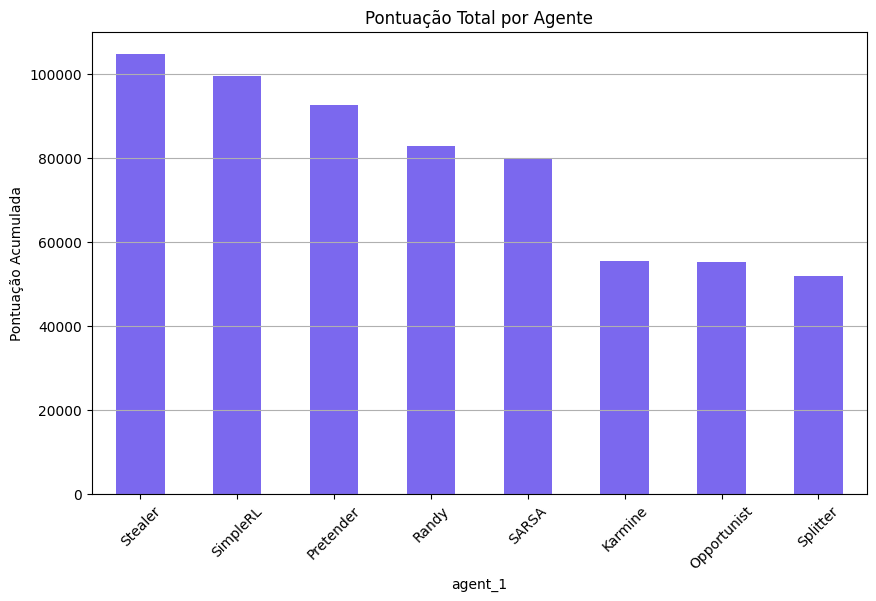

In [ ]:
import matplotlib.pyplot as plt

# Pontuação total por agente
total_scores = df.groupby("agent_1")["score_1"].sum().add(
    df.groupby("agent_2")["score_2"].sum(), fill_value=0
)

total_scores = total_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
total_scores.plot(kind="bar", color="mediumslateblue")
plt.title("Pontuação Total por Agente")
plt.ylabel("Pontuação Acumulada")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Unpivot para ter uma coluna 'agent' e uma 'score'
score1 = df[['round', 'agent_1', 'score_1']].rename(columns={'agent_1': 'agent', 'score_1': 'score'})
score2 = df[['round', 'agent_2', 'score_2']].rename(columns={'agent_2': 'agent', 'score_2': 'score'})
all_scores = pd.concat([score1, score2])

# Agora sim, média por rodada por agente
mean_scores = all_scores.groupby(['agent', 'round'])['score'].mean().reset_index()
# Agrupar por blocos (ex: 50 rodadas) para diminuir pontos no gráfico
mean_scores['round_block'] = (mean_scores['round'] // 50) * 50
block_scores = mean_scores.groupby(['agent', 'round_block'])['score'].mean().reset_index()

fig = px.line(
    block_scores,
    x='round_block',
    y='score',
    color='agent',
    markers=True,
    title='Pontuação Média por Rodadas (Interativo)'
)

fig.update_layout(
    xaxis_title='Rodadas',
    yaxis_title='Pontuação Média',
    legend_title_text='Agente'
)

fig.show()


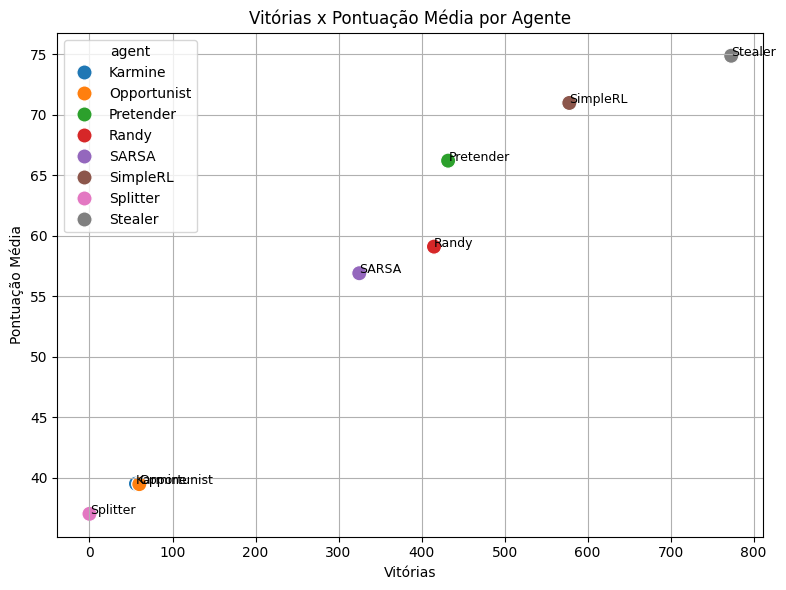

In [ ]:
import seaborn as sns

# Recontar vitórias
def contar_vitorias(df):
    vitorias = {}
    for _, row in df.iterrows():
        if row["score_1"] > row["score_2"]:
            vitorias[row["agent_1"]] = vitorias.get(row["agent_1"], 0) + 1
        elif row["score_2"] > row["score_1"]:
            vitorias[row["agent_2"]] = vitorias.get(row["agent_2"], 0) + 1
    return vitorias

vitorias = contar_vitorias(df)

# Média de pontuação total
media_total = all_scores.groupby("agent")["score"].mean()

# Montar DataFrame
scatter_df = pd.DataFrame({
    "agent": media_total.index,
    "mean_score": media_total.values,
    "wins": [vitorias.get(a, 0) for a in media_total.index]
})

# Plotar
plt.figure(figsize=(8, 6))
sns.scatterplot(data=scatter_df, x="wins", y="mean_score", hue="agent", s=120)

for i in range(len(scatter_df)):
    plt.text(scatter_df["wins"][i]+0.2, scatter_df["mean_score"][i], scatter_df["agent"][i], fontsize=9)

plt.title("Vitórias x Pontuação Média por Agente")
plt.xlabel("Vitórias")
plt.ylabel("Pontuação Média")
plt.grid(True)
plt.tight_layout()
plt.show()

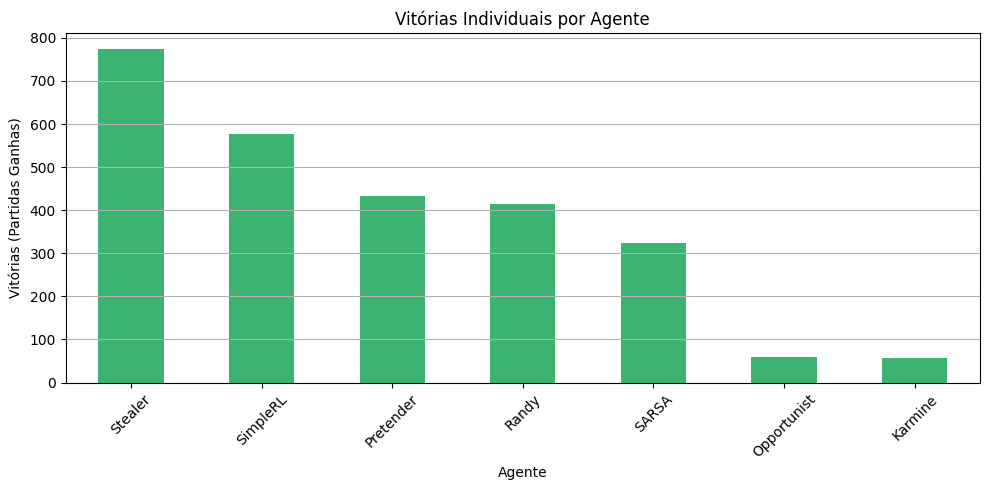

In [ ]:
# Contar vitórias
wins = {}

for _, row in df.iterrows():
    if row["score_1"] > row["score_2"]:
        wins[row["agent_1"]] = wins.get(row["agent_1"], 0) + 1
    elif row["score_2"] > row["score_1"]:
        wins[row["agent_2"]] = wins.get(row["agent_2"], 0) + 1
    # empates não contam

wins_series = pd.Series(wins).sort_values(ascending=False)

# Plotar
plt.figure(figsize=(10, 5))
wins_series.plot(kind="bar", color="mediumseagreen")
plt.title("Vitórias Individuais por Agente")
plt.xlabel("Agente")
plt.ylabel("Vitórias (Partidas Ganhas)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

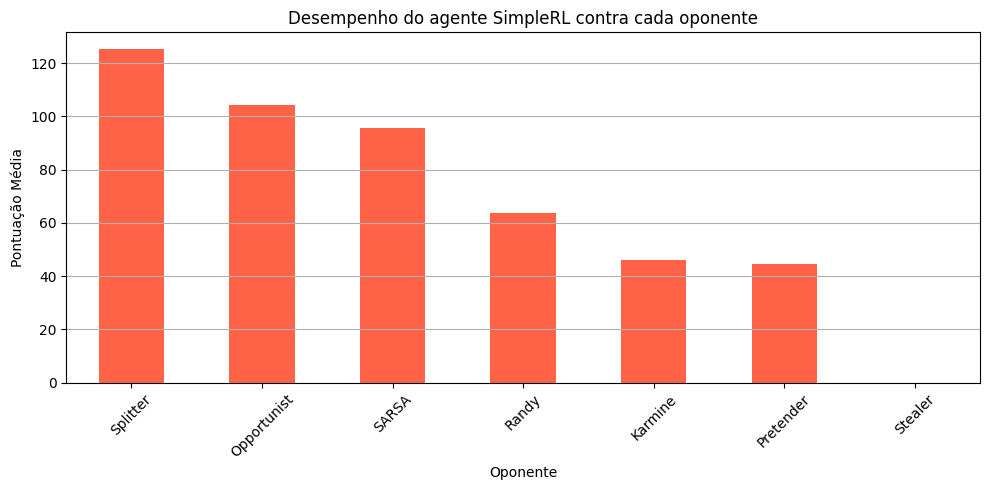

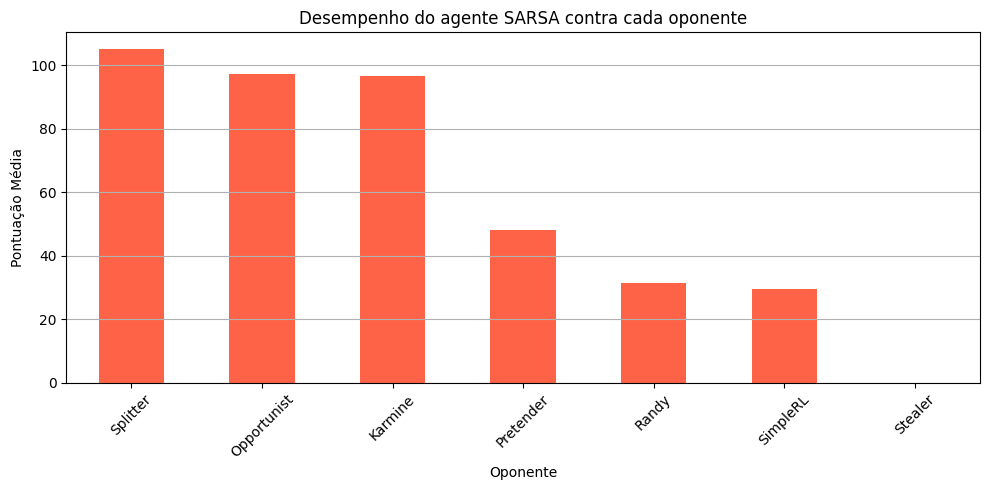

In [ ]:
# Nome dos agentes RL
rl_agents = ["SimpleRL", "SARSA"]

# Lista para armazenar os dados
results_vs = {}

for rl_name in rl_agents:
    results_vs[rl_name] = {}
    for agent in df["agent_1"].unique():
        if agent == rl_name:
            # RL como agent_1
            matches = df[df["agent_1"] == rl_name]
            opponents = matches["agent_2"].unique()
            for opp in opponents:
                opp_matches = matches[matches["agent_2"] == opp]
                avg_score = opp_matches["score_1"].mean()
                results_vs[rl_name][opp] = avg_score
        elif agent in df["agent_2"].unique():
            # RL como agent_2
            matches = df[df["agent_2"] == rl_name]
            opponents = matches["agent_1"].unique()
            for opp in opponents:
                opp_matches = matches[matches["agent_1"] == opp]
                avg_score = opp_matches["score_2"].mean()
                results_vs[rl_name][opp] = avg_score

# Plotar o resultado para cada RL agent
for rl_name, opp_scores in results_vs.items():
    plt.figure(figsize=(10, 5))
    pd.Series(opp_scores).sort_values(ascending=False).plot(kind="bar", color="tomato")
    plt.title(f"Desempenho do agente {rl_name} contra cada oponente")
    plt.ylabel("Pontuação Média")
    plt.xlabel("Oponente")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


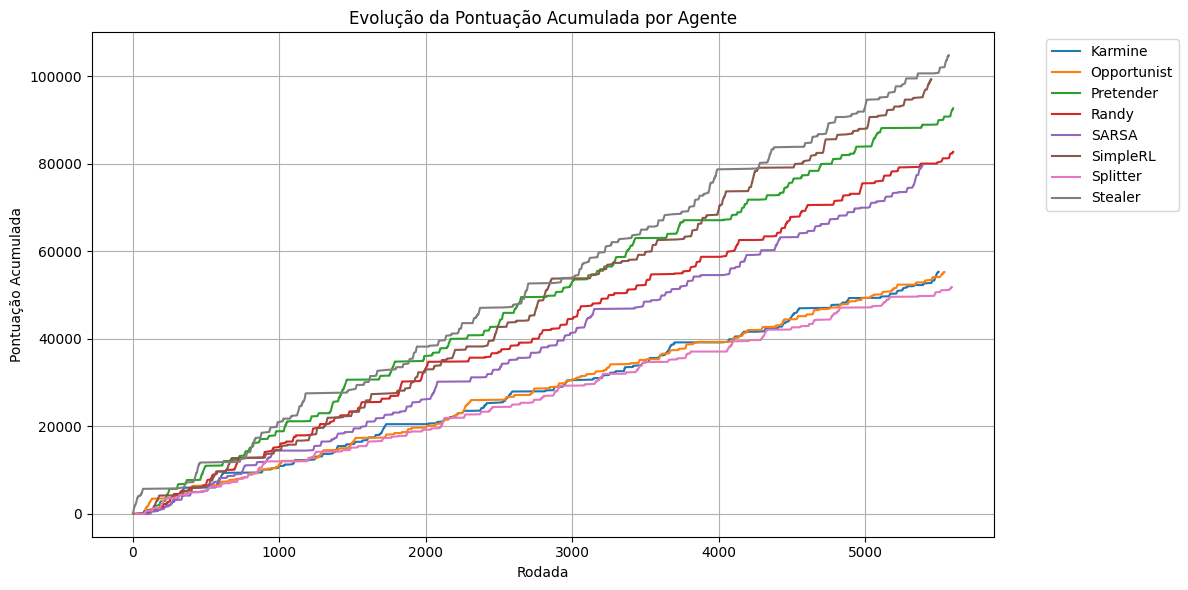

In [ ]:
# Acumulando pontuações por agente ao longo das rodadas
df_long = pd.concat([
    df[["round", "agent_1", "score_1"]].rename(columns={"agent_1": "agent", "score_1": "score"}),
    df[["round", "agent_2", "score_2"]].rename(columns={"agent_2": "agent", "score_2": "score"})
])

df_long = df_long.sort_values("round")
df_long["cum_score"] = df_long.groupby("agent")["score"].cumsum()

plt.figure(figsize=(12, 6))
for agent, group in df_long.groupby("agent"):
    plt.plot(group["round"], group["cum_score"], label=agent)

plt.title("Evolução da Pontuação Acumulada por Agente")
plt.xlabel("Rodada")
plt.ylabel("Pontuação Acumulada")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

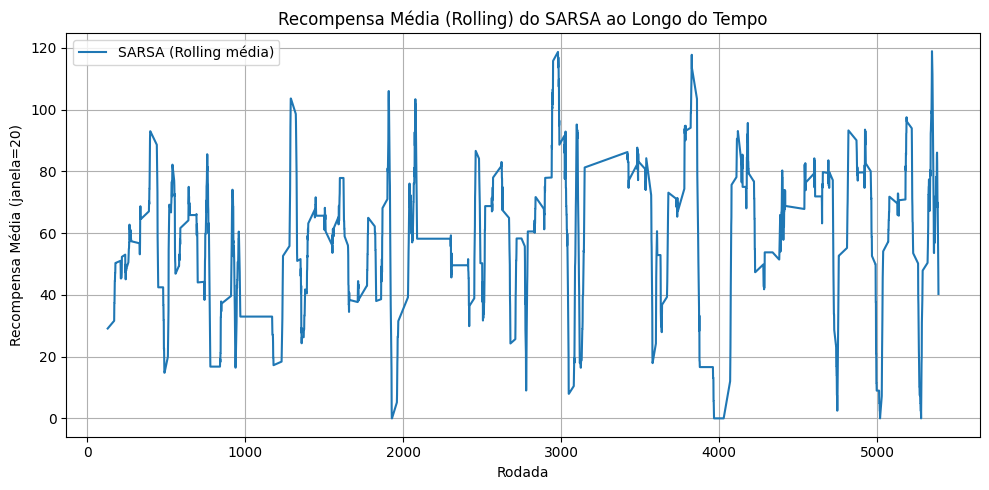

In [ ]:
sarsa_df = df[(df["agent_1"] == "SARSA") | (df["agent_2"] == "SARSA")].copy()

# Calcular score total por rodada
sarsa_df["score"] = sarsa_df.apply(
    lambda row: row["score_1"] if row["agent_1"] == "SARSA" else row["score_2"], axis=1
)

# Rolling média com janela de 20 rodadas
rolling = sarsa_df.sort_values("round")["score"].rolling(20).mean()

plt.figure(figsize=(10, 5))
plt.plot(rolling, label="SARSA (Rolling média)")
plt.title("Recompensa Média (Rolling) do SARSA ao Longo do Tempo")
plt.xlabel("Rodada")
plt.ylabel("Recompensa Média (janela=20)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



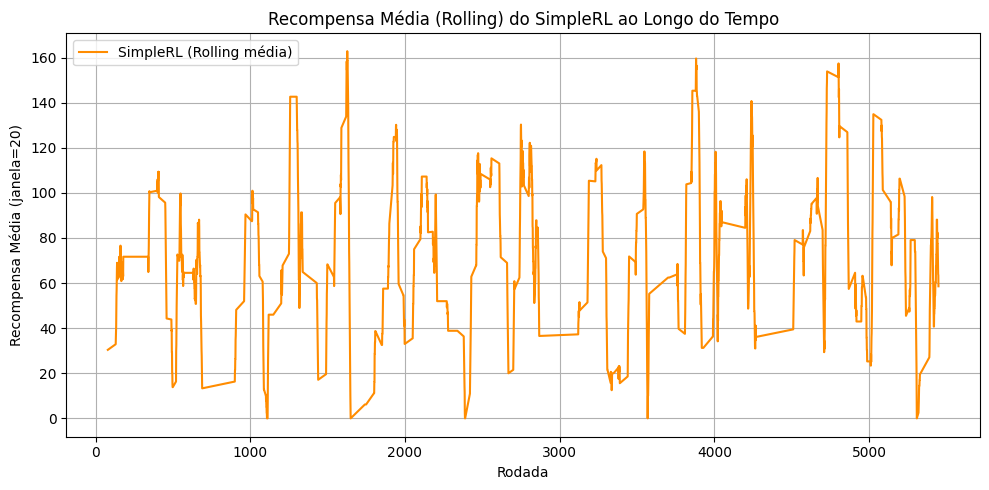

In [ ]:
# Analisar o desempenho do SimpleRL
simplerl_df = df[(df["agent_1"] == "SimpleRL") | (df["agent_2"] == "SimpleRL")].copy()

# Calcular o score obtido em cada rodada
simplerl_df["score"] = simplerl_df.apply(
    lambda row: row["score_1"] if row["agent_1"] == "SimpleRL" else row["score_2"], axis=1
)

# Ordenar e calcular média móvel
rolling_simple = simplerl_df.sort_values("round")["score"].rolling(20).mean()

# Plotar
plt.figure(figsize=(10, 5))
plt.plot(rolling_simple, label="SimpleRL (Rolling média)", color="darkorange")
plt.title("Recompensa Média (Rolling) do SimpleRL ao Longo do Tempo")
plt.xlabel("Rodada")
plt.ylabel("Recompensa Média (janela=20)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

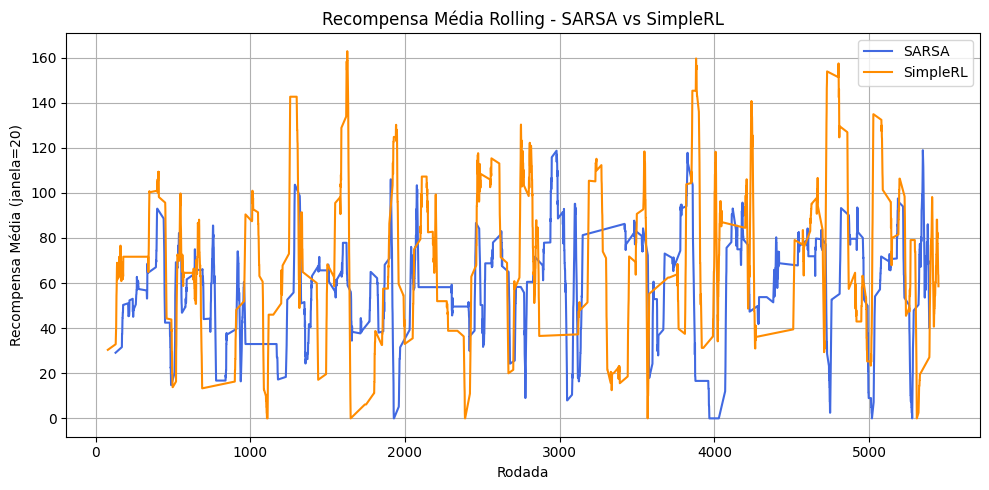

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(rolling, label="SARSA", color="royalblue")
plt.plot(rolling_simple, label="SimpleRL", color="darkorange")
plt.title("Recompensa Média Rolling - SARSA vs SimpleRL")
plt.xlabel("Rodada")
plt.ylabel("Recompensa Média (janela=20)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px



# Reformular o dataframe: uma linha por agente por rodada
df1 = df[['round', 'agent_1', 'score_1']].rename(columns={"agent_1": "agent", "score_1": "score"})
df2 = df[['round', 'agent_2', 'score_2']].rename(columns={"agent_2": "agent", "score_2": "score"})
df_all = pd.concat([df1, df2])

# Agrupar por blocos (ex: a cada 50 rodadas) para suavizar o gráfico
df_all['round_block'] = (df_all['round'] // 50) * 50

# Calcular a média da pontuação por agente e bloco
mean_scores = df_all.groupby(['agent', 'round_block'])['score'].mean().reset_index()

# Filtrar apenas os agentes de interesse, se quiser
agents_to_plot = ["SimpleRL", "SARSA"]
filtered_scores = mean_scores[mean_scores['agent'].isin(agents_to_plot)]

# Plotar com Plotly
fig = px.line(
    filtered_scores,
    x='round_block',
    y='score',
    color='agent',
    markers=True,
    title='Evolução da Pontuação Média - SimpleRL vs SARSA'
)

fig.update_layout(
    xaxis_title='Rodada (agrupado por blocos)',
    yaxis_title='Pontuação média',
    legend_title='Agente',
    template='plotly_white'
)

fig.show()